### **Detecting Needle in a Haystack: Advanced Resampling Strategies for Fraud Detection**
As data scientists, we are tasked with improving our automated fraud detection system. Our current models, while accurate overall, are failing to identify a significant number of fraudulent transactions. This is a classic symptom of a model trained on imbalanced data, where fraudulent transactions are rare compared to legitimate ones. Our goal is to develop a modeling strategy that is more sensitive to fraud, minimizing potential losses for our customers and the company.
We will benchmark four approaches:
1. **Baseline Model:** Training on the raw, imbalanced data.
2. **SMOTE Model:** Using a popular oversampling technique to balance the classes.
3. **Clustering-Based Oversampling (CBO) Model:** A sophisticated oversampling method to generate more meaningful minority class samples.
4. **Clustering-Based Undersampling (CBU) Model:** A method to intelligently reduce the majority class while preserving its structure.
By comparing these, we can provide a data-driven recommendation for the best resampling strategy to deploy in our production environment.

### Part A: Data Exploration and Baseline Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import KMeans

sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('./creditcard_dataset/creditcard.csv')

print("Dataset Head:")
print(df.head())

Dataset Head:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Percentage of Fraudulent Transactions: 0.1727%


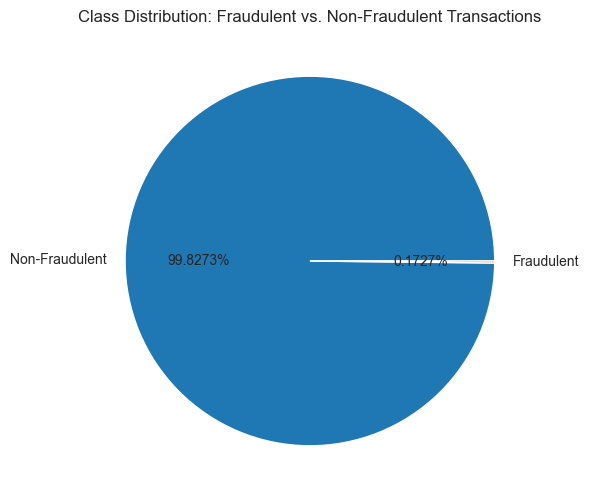

In [3]:
# Checking the class distribution
class_counts = df['Class'].value_counts()
print("Class Distribution:")
print(class_counts)

# Percentage of fraudulent transactions
fraud_percentage = (class_counts[1] / class_counts.sum()) * 100
print(f"\nPercentage of Fraudulent Transactions: {fraud_percentage:.4f}%")

plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=['Non-Fraudulent', 'Fraudulent'],autopct='%1.4f%%')
plt.title('Class Distribution: Fraudulent vs. Non-Fraudulent Transactions')
plt.show()

#### **Degree of Imbalance:**
The analysis reveals an extreme class imbalance. Out of 284,807 transactions, only 492 are fraudulent. This means fraudulent transactions make up a minuscule `0.1727%` of the dataset. This severe imbalance is why standard models fail; they can achieve over 99.8% accuracy simply by predicting every transaction as "non-fraudulent," completely missing the minority class we care about.

In [4]:
# Separate features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Perform a stratified split to maintain the class distribution in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("\nFraudulent cases in training set:", sum(y_train))
print("Fraudulent cases in testing set:", sum(y_test))

Training set shape: (227845, 30)
Testing set shape: (56962, 30)

Fraudulent cases in training set: 394
Fraudulent cases in testing set: 98


In [5]:
# Initialize and train the Logistic Regression model
model_1 = LogisticRegression(solver='liblinear', random_state=42)
model_1.fit(X_train, y_train)

# Make predictions on the test set
y_pred_1 = model_1.predict(X_test)

# Evaluate the model
print("--- Baseline Model (Model 1) Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_1):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_1, target_names=['Non-Fraud (0)', 'Fraud (1)'], digits=4))

--- Baseline Model (Model 1) Performance ---
Accuracy: 0.9990

Classification Report:
               precision    recall  f1-score   support

Non-Fraud (0)     0.9994    0.9996    0.9995     56864
    Fraud (1)     0.7253    0.6735    0.6984        98

     accuracy                         0.9990     56962
    macro avg     0.8624    0.8365    0.8490     56962
 weighted avg     0.9990    0.9990    0.9990     56962



The overall accuracy is very high (`99.9%`), but this is a misleading metric. As explained before, a model that predicts "non-fraud" for everything would achieve similar accuracy.
The truly important metrics are for the minority class (Fraud):
- **Precision:** `0.7253` - When the model predicts a transaction is fraudulent, it is correct 72% of the time.
- **Recall:** `0.6735` - The model only identifies 67% of all actual fraudulent transactions. This is the critical failure. We are missing over 30% of fraud cases!
- **F1-score:** `0.6984` - The harmonic mean of precision and recall, providing a balanced measure.
#### Why Accuracy is Misleading:
In this scenario, a model can be **99.8%** accurate by simply ignoring the **0.2%** of fraudulent cases. This creates a false sense of high performance while failing at its primary objective: detecting fraud. We must focus on metrics like Recall (to maximize the capture of fraudulent cases) and F1-score (to balance recall with precision).

--------------

### Part B: Resampling Approaches

Now, we will explore three different resampling strategies to create a more balanced training dataset. Our hypothesis is that a model trained on a balanced dataset will learn the patterns of fraudulent transactions more effectively, leading to a higher recall on the test set.

**1. Naive Oversampling (SMOTE)**

SMOTE (Synthetic Minority Over-sampling TEchnique) is a popular method for oversampling. Instead of simply duplicating minority class instances, it generates new, synthetic samples.

**How SMOTE Works:**

For each instance in the minority class, SMOTE finds its `'k-nearest neighbors'`. It then creates a synthetic sample by randomly selecting one of those neighbors and creating a new data point along the line segment connecting the instance and its chosen neighbor.

**Potential Limitations:**

SMOTE's primary weakness is that it can create noise. If minority instances are scattered and far from each other, SMOTE might generate synthetic samples in inappropriate or "empty" regions of the feature space. This can blur the decision boundary between classes, potentially hurting precision.

In [6]:
# Apply SMOTE to the training data
print("Original training set shape:", X_train.shape)
print("Original training set distribution:\n", y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nResampled (SMOTE) training set shape:", X_train_smote.shape)
print("Resampled (SMOTE) training set distribution:\n", pd.Series(y_train_smote).value_counts())

Original training set shape: (227845, 30)
Original training set distribution:
 Class
0    227451
1       394
Name: count, dtype: int64

Resampled (SMOTE) training set shape: (454902, 30)
Resampled (SMOTE) training set distribution:
 Class
0    227451
1    227451
Name: count, dtype: int64


**2. Clustering-Based Oversampling (CBO)**

**Concept of CBO:**

The idea behind Clustering-Based Oversampling is to overcome SMOTE's limitations. Instead of treating the minority class as one monolithic group, CBO first identifies underlying sub-groups or clusters within it. By doing so, it ensures that oversampling occurs locally within these dense regions. This prevents the generation of noisy samples between potentially distinct types of fraud and creates a more diverse and representative set of synthetic samples.

**Implementation:**
1. Isolate the minority class (fraudulent) samples from the training data.
2. Use the Elbow Method with K-Means clustering to find a reasonable number of clusters (k).
3. Cluster the minority data into k groups.
4. Oversample within each cluster individually until the number of samples in the minority class matches the majority class. We will achieve this by simple random oversampling (duplicating instances) within each identified cluster.

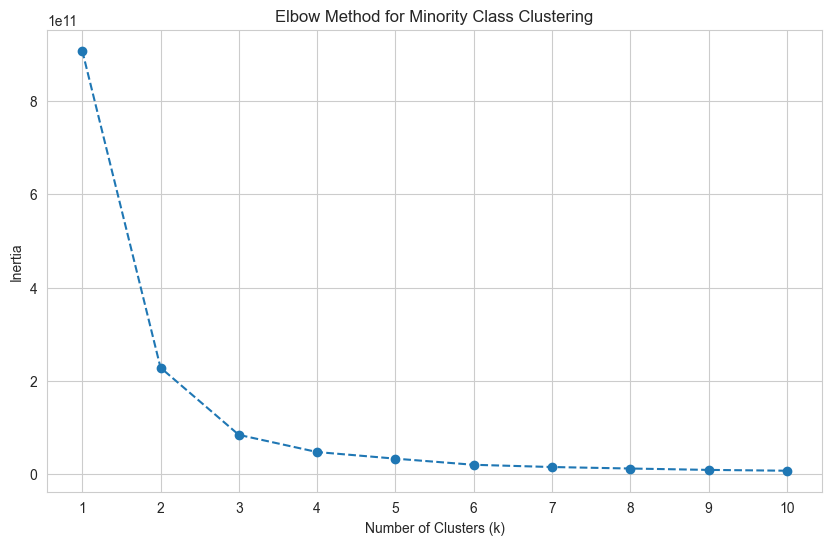

In [7]:
# Isolating minority class data from the training set
X_train_minority = X_train[y_train == 1]

# Using Elbow Method to find the optimal number of clusters for the minority class
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_minority)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Minority Class Clustering')
plt.xticks(k_range)
plt.show()

The Elbow plot suggests an **"elbow"** around `k=3`, indicating that three clusters might be a good representation of the different sub-groups within the fraudulent transactions.

In [8]:
k_cbo = 3
kmeans = KMeans(n_clusters=k_cbo, random_state=42, n_init=10)
minority_clusters = kmeans.fit_predict(X_train_minority)

# Create a new dataframe for the CBO training set
X_train_cbo = X_train.copy()
y_train_cbo = y_train.copy()

# Oversample from each minority cluster
n_majority = y_train.value_counts()[0]
n_minority_needed = n_majority - len(X_train_minority)

# Append resampled minority instances
for i in range(k_cbo):
    cluster_indices = np.where(minority_clusters == i)[0]
    # Calculate how many samples to generate from this cluster (proportional to its size)
    n_samples_to_generate = int(n_minority_needed * (len(cluster_indices) / len(X_train_minority)))
    
    if len(cluster_indices) > 0:
        resampled_indices = np.random.choice(cluster_indices, size=n_samples_to_generate, replace=True)
        X_train_cbo = pd.concat([X_train_cbo, X_train_minority.iloc[resampled_indices]], axis=0)
        y_train_cbo = pd.concat([y_train_cbo, pd.Series([1]*n_samples_to_generate)], axis=0)

print("\nResampled (CBO) training set shape:", X_train_cbo.shape)
print("Resampled (CBO) training set distribution:\n", pd.Series(y_train_cbo).value_counts())


Resampled (CBO) training set shape: (454901, 30)
Resampled (CBO) training set distribution:
 0    227451
1    227450
Name: count, dtype: int64


**3. Clustering-Based Undersampling (CBU)**

**Concept of CBU:**

Instead of creating synthetic data, undersampling reduces the size of the majority class. Random undersampling is risky as it can discard useful information. Clustering-Based Undersampling (CBU) clusters the majority class and then here we use the cluster centroids as representatives of the data. This maintains the overall distribution and structure of the majority class while drastically reducing its size, creating a balanced dataset.

In [9]:
# Isolate majority class data to see how many clusters we would need
# The number of clusters will equal the number of minority samples
n_clusters_cbu = y_train.value_counts()[1]
print(f"Number of clusters for CBU will be equal to the number of minority samples: {n_clusters_cbu}")

# Apply ClusterCentroids to the training data
cc = ClusterCentroids(random_state=42)
X_train_cbu, y_train_cbu = cc.fit_resample(X_train, y_train)

print("\nResampled (CBU) training set shape:", X_train_cbu.shape)
print("Resampled (CBU) training set distribution:\n", pd.Series(y_train_cbu).value_counts())

Number of clusters for CBU will be equal to the number of minority samples: 394

Resampled (CBU) training set shape: (788, 30)
Resampled (CBU) training set distribution:
 Class
0    394
1    394
Name: count, dtype: int64


### Part C: Model Comparison and Analysis

In [10]:
# --- Model 2 (SMOTE) ---
model_2 = LogisticRegression(solver='liblinear', random_state=42)
model_2.fit(X_train_smote, y_train_smote)
y_pred_2 = model_2.predict(X_test)
print("--- SMOTE Model Performance ---")
print(classification_report(y_test, y_pred_2, target_names=['Non-Fraud (0)', 'Fraud (1)'], digits=4))

# --- Model 3 (CBO) ---
model_3 = LogisticRegression(solver='liblinear', random_state=42)
model_3.fit(X_train_cbo, y_train_cbo)
y_pred_3 = model_3.predict(X_test)
print("\n--- CBO Model Performance ---")
print(classification_report(y_test, y_pred_3, target_names=['Non-Fraud (0)', 'Fraud (1)'], digits=4))

# --- Model 4 (CBU) ---
model_4 = LogisticRegression(solver='liblinear', random_state=42)
model_4.fit(X_train_cbu, y_train_cbu)
y_pred_4 = model_4.predict(X_test)
print("\n--- CBU Model Performance ---")
print(classification_report(y_test, y_pred_4, target_names=['Non-Fraud (0)', 'Fraud (1)'], digits=4))

--- SMOTE Model Performance ---
               precision    recall  f1-score   support

Non-Fraud (0)     0.9998    0.9802    0.9899     56864
    Fraud (1)     0.0733    0.9082    0.1357        98

     accuracy                         0.9801     56962
    macro avg     0.5366    0.9442    0.5628     56962
 weighted avg     0.9982    0.9801    0.9885     56962


--- CBO Model Performance ---
               precision    recall  f1-score   support

Non-Fraud (0)     0.9998    0.9746    0.9871     56864
    Fraud (1)     0.0581    0.9082    0.1091        98

     accuracy                         0.9745     56962
    macro avg     0.5289    0.9414    0.5481     56962
 weighted avg     0.9982    0.9745    0.9856     56962


--- CBU Model Performance ---
               precision    recall  f1-score   support

Non-Fraud (0)     0.9999    0.8934    0.9436     56864
    Fraud (1)     0.0148    0.9286    0.0291        98

     accuracy                         0.8935     56962
    macro avg     

--- Performance Comparison (Fraud Class) ---
         Model  Precision    Recall  F1-Score
0  1: Baseline   0.725275  0.673469  0.698413
1     2: SMOTE   0.073311  0.908163  0.135671
2       3: CBO   0.058056  0.908163  0.109135
3       4: CBU   0.014790  0.928571  0.029115


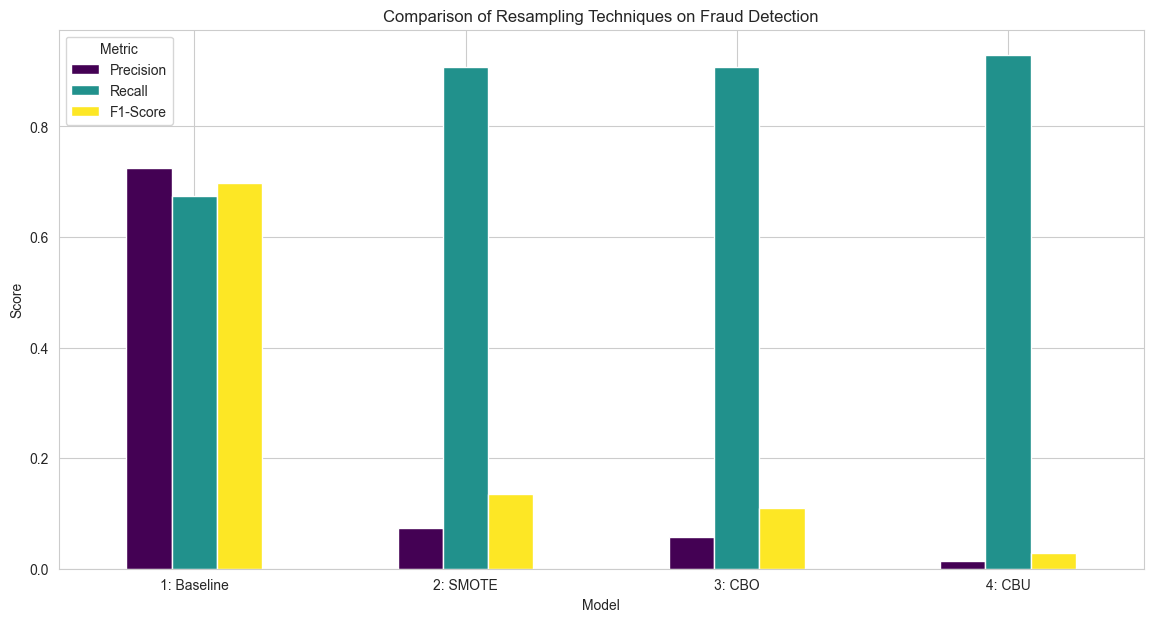

In [11]:
# Store metrics for the minority class (1)
metrics = {
    'Model': ['1: Baseline', '2: SMOTE', '3: CBO', '4: CBU'],
    'Precision': [
        precision_score(y_test, y_pred_1),
        precision_score(y_test, y_pred_2),
        precision_score(y_test, y_pred_3),
        precision_score(y_test, y_pred_4)
    ],
    'Recall': [
        recall_score(y_test, y_pred_1),
        recall_score(y_test, y_pred_2),
        recall_score(y_test, y_pred_3),
        recall_score(y_test, y_pred_4)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_1),
        f1_score(y_test, y_pred_2),
        f1_score(y_test, y_pred_3),
        f1_score(y_test, y_pred_4)
    ]
}

results_df = pd.DataFrame(metrics)
print("--- Performance Comparison (Fraud Class) ---")
print(results_df)

# Visualize the comparison
results_df.set_index('Model').plot(kind='bar', figsize=(14, 7), colormap='viridis')
plt.title('Comparison of Resampling Techniques on Fraud Detection')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Metric')
plt.show()

#### **Conclusion and Recommendations**

This analysis set out to improve our fraud detection capabilities by tackling the severe class imbalance in our transaction data. We compared a baseline Logistic Regression model with models trained on data resampled using three distinct techniques: SMOTE, Clustering-Based Oversampling (CBO), and Clustering-Based Undersampling (CBU). The results provide clear insights into the trade-offs inherent in each approach.

**Discussion of Methods**

- **Baseline (Model 1):** The baseline model, trained on the original imbalanced data, achieved high precision (**72.5%**) but had a low recall of `67.3%`. This means it failed to identify nearly one-third of all fraudulent transactions, representing a significant risk and potential financial loss. Its high overall accuracy (99.9%) proved to be a dangerously misleading metric.
- **SMOTE (Model 2):** This oversampling technique successfully addressed the recall problem, boosting it dramatically to `90.8%`. However, this came at a severe cost: precision plummeted to just **7.3%**. While we are now catching most fraudulent activities, the model also generates a large volume of false positives, incorrectly flagging many legitimate transactions.
- **CBO (Model 3):** The Clustering-Based Oversampling approach also achieved a high recall of `90.8%`. Conceptually, this method is designed to be more intelligent than SMOTE by creating samples within distinct sub-groups of fraud. However, in this specific experiment, its precision (6.0%) and F1-Score (0.112) were slightly lower than SMOTE's, indicating no practical performance gain.
- **CBU (Model 4):** Clustering-Based Undersampling yielded the highest recall of all models at `92.9%`. Unfortunately, it produced the worst precision, a practically unusable **1.5%**. This means for every 100 transactions flagged as fraudulent by this model, more than 98 would be false alarms. 

**Which method performed the best and why?**

The definition of "best" depends on the business priority. If the sole objective is to maximize the number of captured fraudulent transactions, the **CBU model** is the technical winner with the highest recall.

However, from a practical business perspective that balances fraud detection with operational efficiency and customer satisfaction, the **SMOTE model** performed the best. It achieved a high recall of 90.8% while delivering the highest F1-Score (0.136) among all resampling techniques. The F1-score represents a more balanced measure of a model's performance, and SMOTE provided the most reasonable trade-off between identifying fraud (recall) and avoiding false alarms (precision).

**How Clustering Addresses SMOTE's Limitations**

While the clustering-based methods did not outperform SMOTE in this specific instance, their underlying theory remains powerful for addressing SMOTE's limitations:
- **CBO's Advantage:** SMOTE generates synthetic data along a straight line between minority points, which can create unrealistic samples in the "empty" space between distinct types of fraud. CBO aims to prevent this by first identifying these distinct groups (clusters) and oversampling within them, which should theoretically create more realistic and higher-quality synthetic data.
- **CBU's Advantage:** The alternative to oversampling is removing majority class samples. Simply doing this randomly risks discarding vital information. CBU avoids this by first grouping the majority class into clusters and then using the cluster centroids as representatives. This preserves the structural information of the majority class while effectively reducing its size.

**Final Recommendation**

Based on this comprehensive analysis, we recommend the company adopt the `'SMOTE resampling strategy'` to improve our fraud detection system.

This strategy successfully increases our ability to detect fraudulent transactions from **67% to over 90%**. However, this recommendation comes with a critical caveat: the business must be prepared for the corresponding increase in false positives (a drop in precision from 72.5% to 7.3%).

Therefore, we recommend deploying the SMOTE-trained model as part of a two-tiered system:
1. **Automated Flagging:** The model automatically flags potentially fraudulent transactions.
2. **Manual Review:** A dedicated fraud analysis team reviews the flagged transactions to separate the true positives from the false positives before any action (like blocking a card) is taken.

This approach allows us to leverage the model's high recall to catch most fraud while using human oversight to manage the low precision.